# **Connecting to InterSystem IRIS Object Model from C# (using XEP API)**

This notebook provides a step-by-step guide for C# developers looking to connect to and interact with Object model of InterSystems IRIS using the InterSystems XEP API.

## Step 1. Prerequisites
XEP is a lightweight .NET API that projects .NET object data as persistent events. A persistent event is an instance of an InterSystems IRIS class (normally a subclass of %Persistent) containing a copy of the data fields in a .NET object. Like any such instance, it can be retrieved by object access, SQL query, or direct global access.

Before writing any code, ensure that all necessary components are installed.
|     Component     |   Status  |                           Check                    |
|-------------------|-----------|----------------------------------------------------|
| InterSystems IRIS | Running   | Ensure the IRIS instance is started and accessible |
| XEP assembly  | Available | You need to have the correct version of the InterSystems IRIS XEP assembly (InterSystems.Data.XEP.dll) available |
| C# project        | Ready     | Your project should be set up in Visual Studio or your preferred IDE |

- You can download the XEP assembly from [Driver packages page](https://intersystems-community.github.io/iris-driver-distribution/).
- If InterSystems IRIS is installed on your local machine or another you have access to, you can find the file in install-dir\dev\dotnet\bin\v4.6.2 or similar, where install-dir is the installation directory for the instance.

## Step 2. Creating Proxy Class
To be able to work with persistent events, you need to create a class on the client side to generate objects for storage. To do this, create a new class with the following contents:
<pre>using System;

namespace xep.sample
{
    public class Person
    {
        public string name;
        public DateTime DOB;

        public Person() { }

        //constructor for a Person
        internal Person(string str, DateTime date)
        {
            name = str;
            DOB = date;
        }

        //method to generate test data
        public static Person[] generateSampleData(int objectCount)
        {
            Person[] data = new Person[objectCount];
            for (int i = 0; i < objectCount; i++)
            {
                data[i] = new Person("Doe,John", DateTime.Now);
            }
            return data;
        }
    }
}
</pre>

## Step 3. Adding assemblies to your project
Right-click Dependencies in your project in Solution Explorer → Add Project Reference…

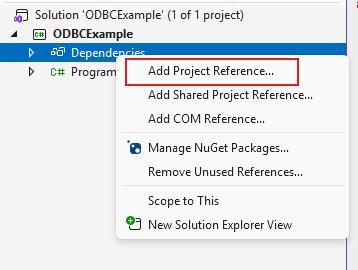

In the Reference Manager window:
Click Browse… on the bottom right. Locate InterSystems.Data.XEP.dll file. Click Add and OK.

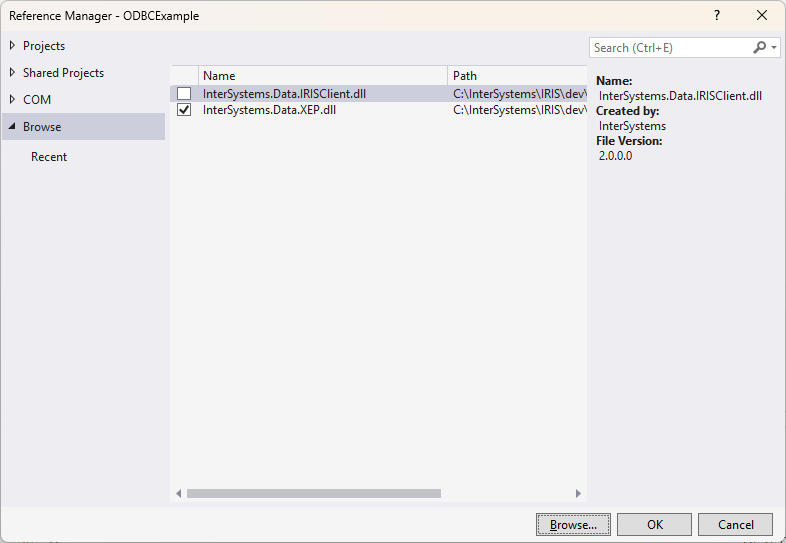

Do the same for InterSystems.Data.IRISClient.dll file.


## Step 5. Writing C# code to store data in the database
- In the dedicated class add links to the assemblies:
<pre>using InterSystems.XEP;
using xep.sample;
</pre>
- Create objects you wish to store in the database
<pre>// Generate 12 SingleStringSample objects for use as test data
Person[] sampleArray = Person.generateSampleData(12);
</pre>
- Create an EventPersister and connect to the database
<pre>EventPersister xepPersister = PersisterFactory.CreatePersister();

String host = "127.0.0.1"; // InterSystems IRIS host
int port = 1972; // InterSystems IRIS Superserver port
String irisnamespace = "USER"; // InterSystems IRIS namespace
String username = "_system"; // Credentials for InterSystems IRIS
String password = "SYS"; //Credentials for InterSystems IRIS

xepPersister.Connect(host, port, irisnamespace, username, password);
</pre>
- Import schema
<pre>xepPersister.ImportSchema("xep.sample.Person");
</pre>
- Create an event and link it to the class
<pre>Event xepEvent = xepPersister.GetEvent("xep.sample.Person");
</pre>
- Save 12 created objects of class xep.sample.Person to the database
<pre>xepEvent.Store(sampleArray);
</pre>
- Close and release all resources
<pre>xepEvent.Close();
xepPersister.Close();
</pre>

## Step 6. Writing C# code to read objects from the database using SQL query
- In the same class write a query statement
<pre>String sqlQuery = "SELECT * FROM xep_sample.Person WHERE %ID BETWEEN ? AND ?";
</pre>
- create an EventQuery and execute it
<pre>EventQuery<Person> xepQuery = xepEvent.CreateQuery<Person>(sqlQuery);
xepQuery.AddParameter(3);    // assign value 3 to first SQL parameter
xepQuery.AddParameter(12);   // assign value 12 to second SQL parameter
xepQuery.Execute();            // get resultset for IDs between 3 and 12
</pre>
- Print the results
<pre>Person mySample = xepQuery.GetNext();
while (mySample != null)
{
    Console.WriteLine(mySample.name);
    mySample = xepQuery.GetNext();
}
</pre>
- Close the query
<pre>xepQuery.Close();
</pre>

## Srep 7. Writing C# code to read object from the database
- In the same class using the same event get an object by its ID
<pre>mySample = (Person)xepEvent.GetObject(1);
Console.WriteLine($"Name: {mySample.name}, Date of Birth: {mySample.DOB.ToString("yyyy-MM-dd")}");
</pre>

## Step 8. Writing C# code to change object in the database
- In the same file using the same event either create a new object and substitute the existing object or take the already read object from step 6 and change its properties and then update the object in the database
<pre>Person newP = new Person("Smith,Jane", DateTime.Now);
xepEvent.UpdateObject(1, newP);
</pre>

## Step 9. Writing C# code to delete an object from the database
- In the same file using the same event use the known ID of an object to delete it from the database
<pre>xepEvent.DeleteObject(1);
</pre>

## Resulting class
Here's the whole class:
<pre>using InterSystems.XEP;
using xep.sample;

namespace XepSimpleNamespace
{
    public class XepSimple
    {
        public static void Main(string[] args)
        {
            // Generate 12 SingleStringSample objects for use as test data
            Person[] sampleArray = Person.generateSampleData(12);

            // EventPersister
            EventPersister xepPersister = PersisterFactory.CreatePersister();

            String host = "127.0.0.1"; // InterSystems IRIS host
            int port = 1972; // InterSystems IRIS Superserver port
            String irisnamespace = "USER"; // InterSystems IRIS namespace
            String username = "_system"; // Credentials for InterSystems IRIS
            String password = "SYS"; //Credentials for InterSystems IRIS

            xepPersister.Connect(host, port, irisnamespace, username, password); // connect to localhost
            xepPersister.DeleteExtent("xep.sample.Person");   // remove old test data
            xepPersister.ImportSchema("xep.sample.Person");   // import flat schema

            // Event
            Event xepEvent = xepPersister.GetEvent("xep.sample.Person");
            xepEvent.Store(sampleArray);

            // EventQuery             
            String sqlQuery = "SELECT * FROM xep_sample.Person WHERE %ID BETWEEN ? AND ?";
            EventQuery<Person> xepQuery = xepEvent.CreateQuery<Person>(sqlQuery);
            xepQuery.AddParameter(3);    // assign value 3 to first SQL parameter
            xepQuery.AddParameter(12);   // assign value 12 to second SQL parameter
            xepQuery.Execute();            // get resultset for IDs between 3 and 12

            // Print each item in the resultset
            Console.WriteLine($"\nPrint query result");
            Person mySample = xepQuery.GetNext();
            while (mySample != null)
            {
                Console.WriteLine(mySample.name);
                mySample = xepQuery.GetNext();
            }

            xepQuery.Close();

            //get object with ID = 1
            Console.WriteLine($"\nPrint object data");
            mySample = (Person)xepEvent.GetObject(1);
            Console.WriteLine($"Name: {mySample.name}, Date of Birth: {mySample.DOB.ToString("yyyy-MM-dd")}");

            //change object with ID = 1
            Person newP = new Person("Smith,Jane", DateTime.Now);
            xepEvent.UpdateObject(1, newP);

            //get object with ID = 1
            Console.WriteLine($"\nPrint updatet object data");
            mySample = (Person)xepEvent.GetObject(1);
            Console.WriteLine($"Name: {mySample.name}, Date of Birth: {mySample.DOB.ToString("yyyy-MM-dd")}");
            //see that the properties have different values

            //delete an object with ID = 2
            xepEvent.DeleteObject(2);

            xepEvent.Close();
            xepPersister.Close();
        } 
    } 
}
</pre>
